In [1]:
import os
import sys
from tqdm.notebook import tqdm
import numpy as np
# import psycopg2
import sqlalchemy
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
print(np.__version__)
print(pd.__version__)

1.21.2
1.3.3


In [3]:
import nfp
print(nfp.__version__)

0.2.1


In [4]:
os.chdir('../')

In [5]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule
from rlmolecule.sql.run_config import RunConfig
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore
from rlmolecule.crystal import utils

/home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_energy


## Compare with the hull energy for relaxed structures

In [6]:
decomp_energy_file = "outputs/relaxed-hull-energies.tsv"
df = pd.read_table(decomp_energy_file, index_col=0,
                   names=["energyperatom", "decomp_energy"],
                   na_values=["None"]
                  )
print(len(df))
df.head(2)

67816


,energyperatom,decomp_energy
Na1Cd1Si1Cl4P1_sg11_icsd_065346_3,-3.460152,0.193
Na2Hg1Si1O1N2_sg14_icsd_170588_4,-4.687541,0.561


In [7]:
# df['comp_type'] = df2['comp_type']
# df = df[~df['comp_type'].isin([11, 12, 13])]

In [8]:
len(df)

67816

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='energyperatom', ylabel='decomp_energy'>

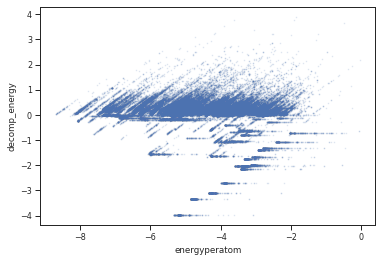

In [9]:
df.plot.scatter(x="energyperatom", y="decomp_energy",
                s=1, alpha=0.1,
               )
# plt.title("Relaxed battery structure decomposition energies")
# out_file = decomp_energy_file.replace('.tsv', '.png')
# plt.savefig(out_file)

In [34]:
df

,energyperatom,decomp_energy
Na1Cd1Si1Cl4P1_sg11_icsd_065346_3,-3.460152,0.193
Na2Hg1Si1O1N2_sg14_icsd_170588_4,-4.687541,0.561


## Compare with decomposition energy calculated from the GNN's predicted eV/atom (trained and tested on relaxed structures)

In [10]:
base_dir = "/projects/rlmolecule/jlaw/crystal-gnn-fork"
pred_decomp_energy_file = f"{base_dir}/outputs/icsd_battery_relaxed/hypo_vsad5_icsd_vsad5_seed1/overall_battery_pred_err_decomp_energy.csv"
df_pred = pd.read_csv(pred_decomp_energy_file, index_col=0,
#                    names=["energyperatom", "decomp_energy"],
#                    na_values=["None"]
                  )
pred_energy_file = f"{base_dir}/outputs/icsd_battery_relaxed/hypo_vsad5_icsd_vsad5_seed1/overall_battery_pred_err.csv"
df_pred2 = pd.read_csv(pred_energy_file, index_col='id')
print(len(df_pred))
df_pred.head(2)

67840


,decomp_energy
id,
K1Al1I4_sg105_icsd_056821_1,0.113
K1Al1I4_sg105_icsd_056821_2,0.091


In [11]:
df_pred2.head(2)

,comp_type,composition,energyperatom,predicted_energyperatom,pred_err,pred_err-0_05
id,,,,,,
Mg2Cl1P1_sg194_icsd_061381_1,112,Mg2Cl1P1,-3.562473,-3.586825,0.024352,0.0
Mg2Cl1P1_sg64_icsd_170268_1,112,Mg2Cl1P1,-3.463860,-3.464951,0.001091,0.0


In [12]:
df2 = pd.concat([df_pred, df_pred2], axis=1, join='inner')
df2.head(2)

,decomp_energy,comp_type,composition,energyperatom,predicted_energyperatom,pred_err,pred_err-0_05
id,,,,,,,
K1Al1I4_sg105_icsd_056821_1,0.113,114,K1Al1I4,-2.577556,-2.656390,0.078834,0.028834
K1Al1I4_sg105_icsd_056821_2,0.091,114,K1Al1I4,-2.570979,-2.677942,0.106962,0.056962


In [13]:
df3 = df2[~df2['comp_type'].isin([11, 12, 13])]
len(df3)

60790

In [14]:
df3.head(2)

,decomp_energy,comp_type,composition,energyperatom,predicted_energyperatom,pred_err,pred_err-0_05
id,,,,,,,
K1Al1I4_sg105_icsd_056821_1,0.113,114,K1Al1I4,-2.577556,-2.656390,0.078834,0.028834
K1Al1I4_sg105_icsd_056821_2,0.091,114,K1Al1I4,-2.570979,-2.677942,0.106962,0.056962


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='energyperatom', ylabel='predicted_energyperatom'>

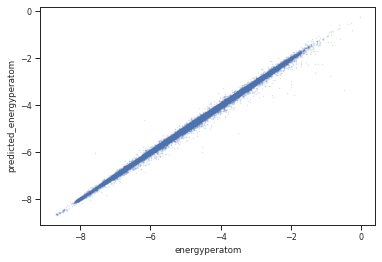

In [15]:
df3.plot.scatter(x="energyperatom", y="predicted_energyperatom",
                s=1, alpha=0.1,
               )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='predicted_energyperatom', ylabel='decomp_energy'>

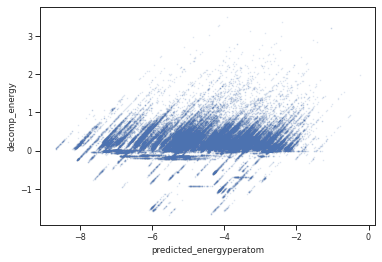

In [16]:
df3.plot.scatter(x="predicted_energyperatom", y="decomp_energy",
                s=1, alpha=0.1,
               )
# plt.title("Relaxed battery structure decomposition energies")
# out_file = decomp_energy_file.replace('.tsv', '.png')
# plt.savefig(out_file)

In [64]:
df3[df3['composition'] == 'Mg1Hf2O5']['energyperatom']

id
Mg1Hf2O5_sg108_icsd_040556_1   -8.504037
Mg1Hf2O5_sg11_icsd_169702_1    -8.385821
Mg1Hf2O5_sg11_icsd_200751_1    -8.578192
Mg1Hf2O5_sg123_icsd_069675_1   -7.457254
Mg1Hf2O5_sg123_icsd_092313_1   -7.520794
Mg1Hf2O5_sg12_icsd_027408_1    -8.507227
Mg1Hf2O5_sg12_icsd_029270_1    -8.640227
Mg1Hf2O5_sg12_icsd_034831_1    -8.640284
Mg1Hf2O5_sg12_icsd_069975_1    -8.676021
Mg1Hf2O5_sg12_icsd_153286_1    -8.465034
Mg1Hf2O5_sg12_icsd_157775_1    -8.467269
Mg1Hf2O5_sg12_icsd_409393_1    -8.395200
Mg1Hf2O5_sg139_icsd_014164_1   -8.084483
Mg1Hf2O5_sg13_icsd_002763_1    -8.641639
Mg1Hf2O5_sg140_icsd_093791_1   -8.183014
Mg1Hf2O5_sg140_icsd_634787_1   -8.318306
Mg1Hf2O5_sg141_icsd_108812_1   -8.490351
Mg1Hf2O5_sg143_icsd_036452_1   -8.476431
Mg1Hf2O5_sg14_icsd_033867_1    -8.470873
Mg1Hf2O5_sg14_icsd_061206_1    -8.667507
Mg1Hf2O5_sg14_icsd_655234_1    -8.574034
Mg1Hf2O5_sg15_icsd_082425_1    -8.492655
Mg1Hf2O5_sg15_icsd_201996_1    -8.641664
Mg1Hf2O5_sg15_icsd_202394_1    -8.648193
Mg1Hf2O5_sg15

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


221 structures predicted to be stable with DFT decomp_energy > .1


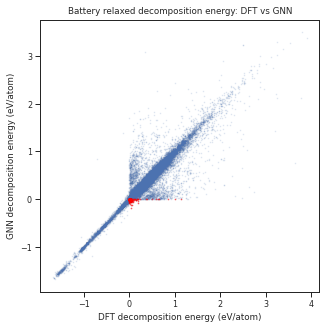

In [33]:
df4 = df.copy()
df4['pred_decomp_energy'] = df3['decomp_energy']

f, ax = plt.subplots(figsize=(5,5))
df4.plot.scatter(x="decomp_energy", y="pred_decomp_energy", ax=ax,
# sns.jointplot(data=df4, x='decomp_energy', y='pred_decomp_energy',
                s=1, alpha=0.1,
               )
cutoff = 0
df4[(df4['pred_decomp_energy'] < 0) & (df4['decomp_energy'] > cutoff)].plot.scatter(x="decomp_energy", y="pred_decomp_energy", ax=ax,
                s=1, alpha=0.4, color='red',
               )
ax.set_ylabel("GNN decomposition energy (eV/atom)")
ax.set_xlabel("DFT decomposition energy (eV/atom)")
ax.set_title("Battery relaxed decomposition energy: DFT vs GNN")

print(f"{len(df4[(df4['pred_decomp_energy'] < 0) & (df4['decomp_energy'] > cutoff)])} structures predicted to be stable with DFT decomp_energy > .1")

In [25]:
# see which decorations have the large error
df4['decomp_err'] = (df4['pred_decomp_energy'] - df4['decomp_energy']).abs()
df4[df4['decomp_err'] > .1]

,energyperatom,decomp_energy,pred_decomp_energy,decomp_err
K1Sb1N2_sg112_icsd_073376_2,-4.444650,1.311,0.875,0.436
Na1Hf1W1O1N3_sg187_icsd_154682_10,-6.162694,1.387,2.083,0.696
K1Zn1B1N1P1_sg11_icsd_094400_113,-4.411674,0.933,0.043,0.890
Zn1W1O1P2_sg140_icsd_411137_4,-4.975690,1.267,0.175,1.092
Zn1W1O1P2_sg63_icsd_413290_6,-5.409167,0.129,0.537,0.408
...,...,...,...,...
Li1Sb1I6_sg166_icsd_247043_2,-1.798240,0.589,0.187,0.402
Na2Zr1P2_sg63_icsd_418162_2,-4.147464,0.007,0.517,0.510
Li1Zn1Hg1O1N1_sg62_icsd_409579_38,-3.282965,0.093,0.705,0.612
Li1Hg1Sb1I5P1_sg13_icsd_085759_20,-1.845335,0.781,0.403,0.378


## Try Bokeh to get point thumbnails

In [18]:
#pip install jupyter_bokeh
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show
# from bokeh.resources import INLINE
import bokeh.io
# bokeh.io.output_notebook(INLINE)
bokeh.io.output_notebook()

Loading BokehJS ...

In [19]:
# from bokeh.io import show
# from bokeh.models import ColumnDataSource, HoverTool
# from bokeh.plotting import figure

In [27]:
source = ColumnDataSource(data=df4[df4['decomp_err'] > .2].reset_index())
p = figure(tools=[HoverTool(tooltips=[('eV/atom', '@energyperatom'),
                                     ('decomp_energy', '@decomp_energy'),
                                     ('pred_decomp_energy', '@pred_decomp_energy'),
                                     ('State', '@index')])])
p.scatter(x="decomp_energy", y="pred_decomp_energy", size=1, source=source)
show(p)

In [37]:
df3.head()

,decomp_energy,comp_type,composition,energyperatom,predicted_energyperatom,pred_err,pred_err-0_05
id,,,,,,,
K1Al1I4_sg105_icsd_056821_1,0.113,114,K1Al1I4,-2.577556,-2.656390,0.078834,0.028834
K1Al1I4_sg105_icsd_056821_2,0.091,114,K1Al1I4,-2.570979,-2.677942,0.106962,0.056962
K1Al1I4_sg109_icsd_084567_1,-0.007,114,K1Al1I4,-2.799428,-2.772838,0.026590,0.000000
K1Al1I4_sg109_icsd_084567_2,-0.057,114,K1Al1I4,-2.799436,-2.823281,0.023845,0.000000
K1Al1I4_sg10_icsd_104188_1,0.083,114,K1Al1I4,-2.665520,-2.685236,0.019716,0.000000


In [52]:
print(len(df3[df3['decomp_energy'] < -1]))
print(len(df3))

512
60790


In [46]:
len(df3[df3['decomp_energy'] < -1]) / len(df3)

0.008422437900970555

In [50]:
len(df[df['decomp_energy'] < -1])

5773

In [51]:
len(df[df['decomp_energy'] < -1]) / len(df)

0.0851274035625811

<AxesSubplot:>

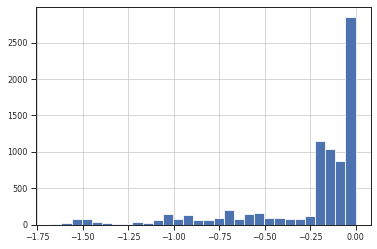

In [42]:
df3[df3['decomp_energy'] < 0]['decomp_energy'].hist(bins=30)

In [ ]:
# are decomposition energies of experimental datasets < 1? 
# Could we use that as a goal?